## importando a base de dados nescessaria

In [1]:
!pip install mlforecast
!pip install lightgbm
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import List
import pickle

import mlforecast
from mlforecast import MLForecast

from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

from utilsforecast.plotting import plot_series

import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from mlforecast import MLForecast
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)

import warnings
warnings.filterwarnings('ignore')

### Funções

In [3]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

## Importando a base de dados

In [4]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [5]:
data = pd.read_parquet(bucket_uri)

In [6]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,value,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,2016-05-22


In [7]:
data['id'].nunique()

30490

In [8]:
data['item_id'].nunique()

3049

In [9]:
data['dept_id'].nunique()

7

In [10]:
data['cat_id'].nunique()

3

In [11]:
data['store_id'].nunique()

10

In [12]:
data['state_id'].nunique()

3

In [13]:
data['date'] = pd.to_datetime(data['date'])

In [14]:
data = data.set_index('date')

## Previsão vendas da empresa✅

In [15]:
df_vendas_empresa_geral = data.drop(columns=["item_id", "dept_id", "cat_id", "store_id", "state_id"])
df_vendas_empresa_geral.reset_index()
df_vendas_empresa_geral = df_vendas_empresa_geral.drop(columns=["id"])

In [16]:
df_vendas_empresa_geral = df_vendas_empresa_geral.reset_index()

In [17]:
#df_vendas_empresa_geral['date'] = pd.to_datetime(data['date'])
df_vendas_empresa_geral.set_index('date', inplace=True)

In [18]:
df_vendas_empresa_geral = df_vendas_empresa_geral.resample('M').sum()

In [19]:
df_vendas_empresa_geral

,value
date,
2011-01-31,88163
2011-02-28,726375
2011-03-31,763567
2011-04-30,737713
2011-05-31,719562
...,...
2016-01-31,1215286
2016-02-29,1212927
2016-03-31,1275746


In [20]:
num_months = df_vendas_empresa_geral.shape[0]

In [21]:
num_months

65

In [22]:
df_vendas_empresa_geral = df_vendas_empresa_geral.reset_index()

In [23]:
df_vendas_empresa_geral

,date,value
0,2011-01-31,88163
1,2011-02-28,726375
2,2011-03-31,763567
3,2011-04-30,737713
4,2011-05-31,719562
...,...,...
60,2016-01-31,1215286
61,2016-02-29,1212927
62,2016-03-31,1275746
63,2016-04-30,1283470


In [24]:
df_nixtla_vendas_totais = pd.DataFrame({
    'unique_id': '0',
    'ds': df_vendas_empresa_geral['date'],
    'y': df_vendas_empresa_geral['value']
})

In [25]:
df_nixtla_vendas_totais

,unique_id,ds,y
0,0,2011-01-31,88163
1,0,2011-02-28,726375
2,0,2011-03-31,763567
3,0,2011-04-30,737713
4,0,2011-05-31,719562
...,...,...,...
60,0,2016-01-31,1215286
61,0,2016-02-29,1212927
62,0,2016-03-31,1275746
63,0,2016-04-30,1283470


In [26]:
df_nixtla_vendas_totais['ds'] = pd.to_datetime(df_nixtla_vendas_totais['ds'])

In [27]:
df_nixtla_vendas_totais['unique_id'].value_counts().sum()

65

In [28]:
df_test = df_nixtla_vendas_totais.groupby('unique_id').tail(6)
df_train = df_nixtla_vendas_totais.drop(df_test.index)

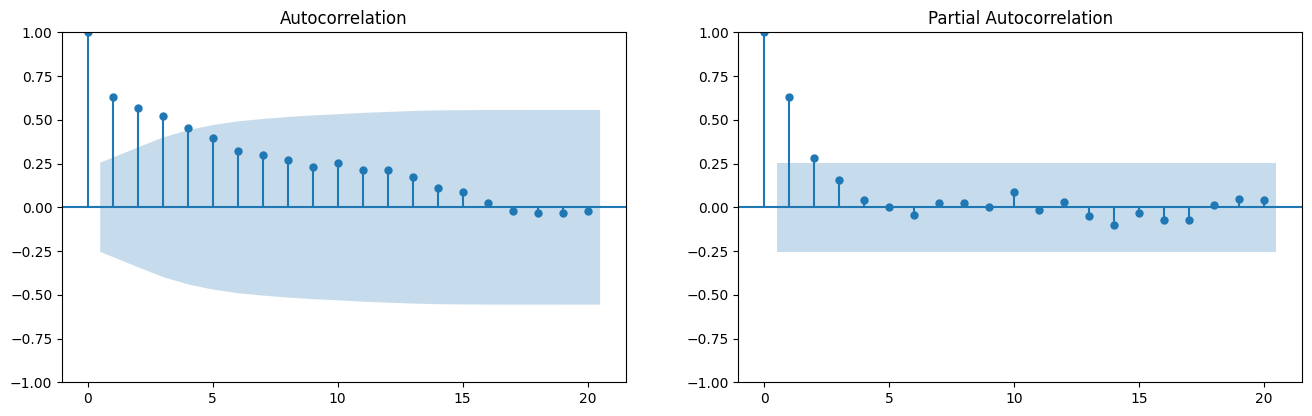

In [29]:
acf_pacf(df_train['y'], 20)

In [30]:
class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

In [31]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'MLPRegressor': MLPRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor(),
    'Naive': Naive()
}

In [32]:
fcst = MLForecast(
    models=models,
    freq='M',
    lags=[1, 2],
)

In [33]:
fcst.fit(df_train, id_col='unique_id', time_col='ds', target_col='y')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 2
[LightGBM] [Info] Start training from score 1035157.684211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

MLForecast(models=[RandomForestRegressor, LinearRegression, MLPRegressor, KNeighborsRegressor, XGBRegressor, LGBMRegressor, Naive], freq=M, lag_features=['lag1', 'lag2'], date_features=[], num_threads=1)

In [34]:
len(df_test)

6

In [35]:
predict = fcst.predict(6)

In [36]:
for i in list(models.keys()):
  predict[i] = predict[i].astype(int)

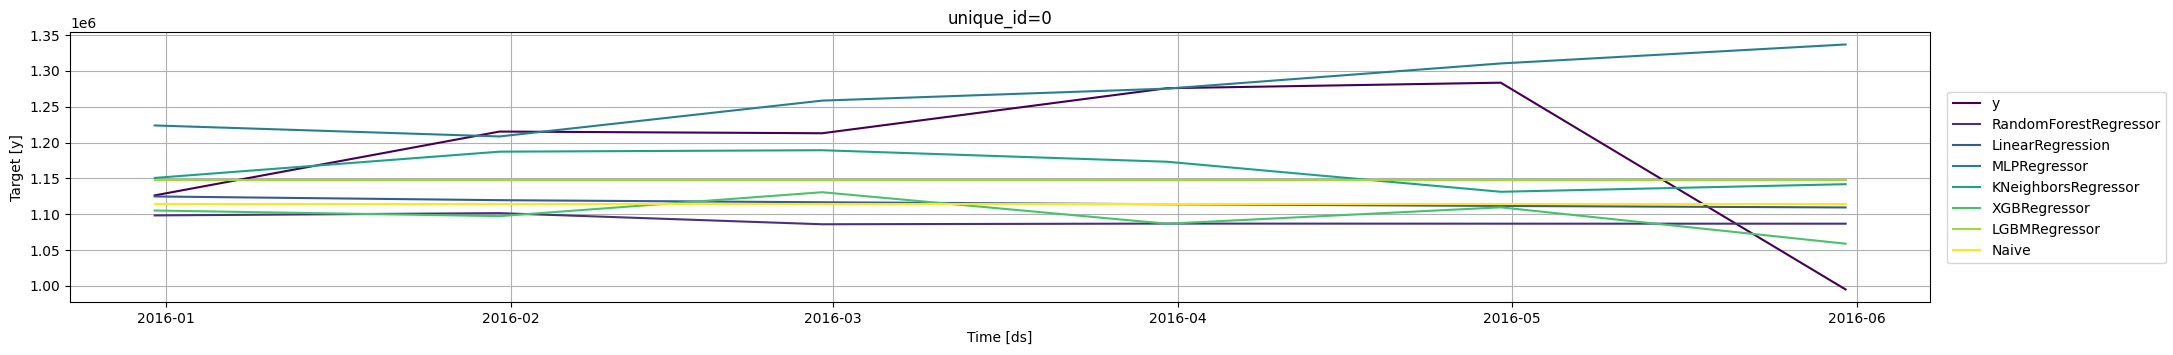

In [37]:
plot_series(df_test, predict, plot_random=False)

In [38]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], predict[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], predict[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(df_test['y'], predict[i]))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], predict[i])
  print(f'R2: {R2}')
  print('\n')

------------------RandomForestRegressor-----------------
Mean Absolute Error: 124342.5
Mean absolute percentage error: 0.10277900623139785
Root mean squared error: 137011.8025919665
R2: -0.9029744726566178


------------------LinearRegression-----------------
Mean Absolute Error: 106949.0
Mean absolute percentage error: 0.08921475239886195
Root mean squared error: 120615.67414035928
R2: -0.4747706951655395


------------------MLPRegressor-----------------
Mean Absolute Error: 86520.0
Mean absolute percentage error: 0.0824427833523464
Root mean squared error: 146732.7971234334
R2: -1.182586150618297


------------------KNeighborsRegressor-----------------
Mean Absolute Error: 79623.5
Mean absolute percentage error: 0.0684737729461776
Root mean squared error: 97637.53976399993
R2: 0.03361393798664081


------------------XGBRegressor-----------------
Mean Absolute Error: 108024.33333333333
Mean absolute percentage error: 0.08858208300464653
Root mean squared error: 123280.9274651463
R2: -

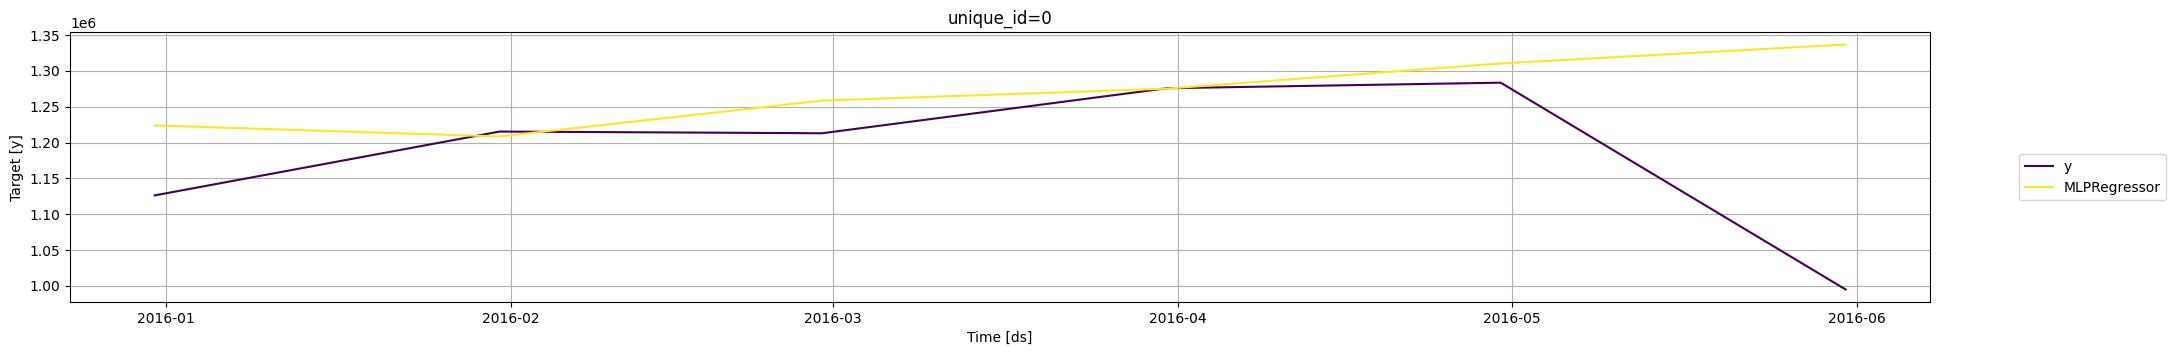

In [39]:
plot_series(df_test, predict[['unique_id', 'ds', 'MLPRegressor']], plot_random=False)

In [40]:
metrics = [mae, rmse, mape]

previsao = df_test.merge(predict, how='right', on=['unique_id', 'ds'])
previsao.head()

,unique_id,ds,y,RandomForestRegressor,LinearRegression,MLPRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor,Naive
0,0,2015-12-31,1126236,1098295,1124766,1223801,1150596,1105139,1148101,1113976
1,0,2016-01-31,1215286,1101479,1119558,1208454,1187225,1097290,1148101,1113976
2,0,2016-02-29,1212927,1085954,1116653,1258455,1189246,1130670,1148101,1113976
3,0,2016-03-31,1275746,1086900,1113907,1275177,1173188,1086711,1148101,1113976
4,0,2016-04-30,1283470,1086771,1111515,1310300,1131279,1109565,1148101,1113976


In [41]:
previsao.to_csv('treinamento/treino_vendas_totais_treino.csv')

In [42]:
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'MLPRegressor': MLPRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor()
}

result_metrics = evaluate(
    df = previsao,
    metrics=metrics,
    models=list(models.keys()))


In [43]:
df_pivot = result_metrics.pivot(index='unique_id', columns='metric')
df_pivot.columns = [f'{col[1]}{col[0]}' for col in df_pivot.columns]
df_pivot.reset_index(inplace=True)

In [44]:
df_pivot

,unique_id,maeRandomForestRegressor,mapeRandomForestRegressor,rmseRandomForestRegressor,maeLinearRegression,mapeLinearRegression,rmseLinearRegression,maeMLPRegressor,mapeMLPRegressor,rmseMLPRegressor,maeKNeighborsRegressor,mapeKNeighborsRegressor,rmseKNeighborsRegressor,maeXGBRegressor,mapeXGBRegressor,rmseXGBRegressor,maeLGBMRegressor,mapeLGBMRegressor,rmseLGBMRegressor
0,0,124342.5,0.102779,137011.802592,106949.0,0.089215,120615.67414,86520.0,0.082443,146732.797123,79623.5,0.068474,97637.539764,108024.333333,0.088582,123280.927465,95001.5,0.08126,105875.518946


In [45]:
best_models = {}

for metric in ['mae', 'mape', 'rmse']:
    best_models[metric] = []
    for idx, row in df_pivot.iterrows():
        min_value = float('inf')
        best_model = None
        for model in models:
            column_name = f'{metric}{model}'
            if row[column_name] < min_value:
                min_value = row[column_name]
                best_model = model
        best_models[metric].append(best_model)

best_models_df_pivot = pd.DataFrame(best_models)
best_models_df_pivot['unique_id'] = df_pivot['unique_id']

for i in ['mae', 'mape', 'rmse']:
  print(best_models_df_pivot[i].value_counts())

mae
KNeighborsRegressor    1
Name: count, dtype: int64
mape
KNeighborsRegressor    1
Name: count, dtype: int64
rmse
KNeighborsRegressor    1
Name: count, dtype: int64


#### Treinando o melhor modelo

In [46]:
models = {
    'MLPRegressor' : MLPRegressor()
}

fcst = MLForecast(
    models=models,
    freq='MS',
    lags=[1, 6, 12]
)


In [47]:
dados_full = pd.concat([df_train, df_test])
fcst.fit(dados_full)

MLForecast(models=[MLPRegressor], freq=MS, lag_features=['lag1', 'lag6', 'lag12'], date_features=[], num_threads=1)

#### caso deseje importar o modelo, faça o download com o picke

In [48]:
with open('Modelos/modelo_previsao_todas_vendas.pkl', 'wb') as file:
    pickle.dump(fcst, file)

In [49]:
previsao = fcst.predict(6)
previsao['MLPRegressor'] = previsao['MLPRegressor'].astype(int)
previsao

,unique_id,ds,MLPRegressor
0,0,2016-06-01,1182327
1,0,2016-07-01,1330511
2,0,2016-08-01,1422417
3,0,2016-09-01,1452857
4,0,2016-10-01,1497551
5,0,2016-11-01,1416673


In [50]:
previsao.to_csv('previsao/previsao_total_vendas_Linear_Regression.csv')